# Power your products with ChatGPT and your own data

This is a walkthrough taking readers through how to build starter Q&A and Chatbot applications using the ChatGPT API and their own data. 

It is laid out in these sections:
- **Setup:** 
    - Initiate variables and source the data
- **Lay the foundations:**
    - Set up the vector database to accept vectors and data
    - Load the dataset, chunk the data up for embedding and store in the vector database
- **Make it a product:**
    - Add a retrieval step where users provide queries and we return the most relevant entries
    - Summarise search results with GPT-3
    - Test out this basic Q&A app in Streamlit
- **Build your moat:**
    - Create an Assistant class to manage context and interact with our bot
    - Use the Chatbot to answer questions using semantic search context
    - Test out this basic Chatbot app in Streamlit
    
Upon completion, you have the building blocks to create your own production chatbot or Q&A application using OpenAI APIs and a vector database.

This notebook was originally presented with [these slides](https://drive.google.com/file/d/1dB-RQhZC_Q1iAsHkNNdkqtxxXqYODFYy/view?usp=share_link), which provide visual context for this journey.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

## Scrape focusedlabs.io
Run a scrapy spider. You should see a json file appear in web-scrape-data.

In [4]:
!{sys.executable} -m scrapy runspider focusedlabs_home_spider.py -o data/focusedlabs-home.jsonl
!{sys.executable} -m scrapy runspider focusedlabs_about_spider.py -o data/focusedlabs-about.jsonl
!{sys.executable} -m scrapy runspider focusedlabs_contact_spider.py -o data/focusedlabs-contact.jsonl
!{sys.executable} -m scrapy runspider focusedlabs_case_studies_spider.py -o data/focusedlabs-case-studies.jsonl

2023-06-07 10:59:52 [scrapy.utils.log] INFO: Scrapy 2.9.0 started (bot: scrapybot)
2023-06-07 10:59:52 [scrapy.utils.log] INFO: Versions: lxml 4.9.2.0, libxml2 2.9.13, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.1, Twisted 22.10.0, Python 3.11.3 (main, Apr  7 2023, 20:13:31) [Clang 14.0.0 (clang-1400.0.29.202)], pyOpenSSL 23.2.0 (OpenSSL 3.1.1 30 May 2023), cryptography 41.0.0, Platform macOS-13.4-arm64-arm-64bit
2023-06-07 10:59:52 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
2023-06-07 10:59:52 [py.warnings] WARNING: /opt/homebrew/lib/python3.11/site-packages/scrapy/utils/request.py:232: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy

## Setup

First we'll setup our libraries and environment variables

In [5]:
import openai
import os
import requests
import numpy as np
import pandas as pd
from typing import Iterator
import tiktoken
import textract
from numpy import array, average

from database import get_redis_connection

# Set our default models and chunking size
from config import COMPLETIONS_MODEL, EMBEDDINGS_MODEL, CHAT_MODEL, TEXT_EMBEDDING_CHUNK_SIZE, VECTOR_FIELD_NAME

# Ignore unclosed SSL socket warnings - optional in case you get these errors
import warnings

warnings.filterwarnings(action="ignore", message="unclosed", category=ImportWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [6]:
pd.set_option('display.max_colwidth', 0)

## Storage

We're going to use Redis as our database for both document contents and the vector embeddings. You will need the full Redis Stack to enable use of Redisearch, which is the module that allows semantic search - more detail is in the [docs for Redis Stack](https://redis.io/docs/stack/get-started/install/docker/).

To set this up locally, you will need to install Docker and then run the following command: ```docker run -d --name redis-stack -p 6379:6379 -p 8001:8001 redis/redis-stack:latest```.

The code used here draws heavily on [this repo](https://github.com/RedisAI/vecsim-demo).

After setting up the Docker instance of Redis Stack, you can follow the below instructions to initiate a Redis connection and create a Hierarchical Navigable Small World (HNSW) index for semantic search.

In [11]:
# Setup Redis
from redis import Redis
from redis.commands.search.query import Query
from redis.commands.search.field import (
    TextField,
    VectorField,
    NumericField
)
from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)

redis_client = get_redis_connection()

In [12]:
# Constants
VECTOR_DIM = 1536 #len(data['title_vector'][0]) # length of the vectors
#VECTOR_NUMBER = len(data)                 # initial number of vectors
PREFIX = "focusedlabsdoc"                            # prefix for the document keys
DISTANCE_METRIC = "COSINE"                # distance metric for the vectors (ex. COSINE, IP, L2)

In [13]:
# Create search index

# Index
INDEX_NAME = "fl-index"           # name of the search index
VECTOR_FIELD_NAME = 'content_vector'

# Define RediSearch fields for each of the columns in the dataset
# This is where you should add any additional metadata you want to capture
filename = TextField("filename")
text_chunk = TextField("text_chunk")
file_chunk_index = NumericField("file_chunk_index")

# define RediSearch vector fields to use HNSW index

text_embedding = VectorField(VECTOR_FIELD_NAME,
    "HNSW", {
        "TYPE": "FLOAT32",
        "DIM": VECTOR_DIM,
        "DISTANCE_METRIC": DISTANCE_METRIC
    }
)
# Add all our field objects to a list to be created as an index
fields = [filename,text_chunk,file_chunk_index,text_embedding]

In [14]:
redis_client.ping()
# Optional to clean db
# redis_client.flushdb()

True

In [15]:
# Optional step to drop the index if it already exists
#redis_client.ft(INDEX_NAME).dropindex()

# Check if index exists
try:
    redis_client.ft(INDEX_NAME).info()
    print("Index already exists")
except Exception as e:
    print(e)
    # Create RediSearch Index
    print('Not there yet. Creating')
    redis_client.ft(INDEX_NAME).create_index(
        fields = fields,
        definition = IndexDefinition(prefix=[PREFIX], index_type=IndexType.HASH)
    )

Unknown Index name
Not there yet. Creating


## Web Text File Ingestion
- Save cleaned text to a csv file
- Tokenize text


In [16]:
import pandas as pd

# Create a list to store the text files
texts=[]

def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

# Get all the text files in the text directory
for file in os.listdir("data/"):

    # Open the file and read the text
    with open("data/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        texts.append((file.replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('data/all-clean-scraped.csv')
df.head()

/var/folders/l8/vrmsbx1j3mlgzqql_xvtsl4m0000gn/T/ipykernel_57304/2064337653.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


fname  \
0  focusedlabs contact.jsonl        
1  focusedlabs home.jsonl           
2  focusedlabs case studies.jsonl   
3  focusedlabs about.jsonl          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

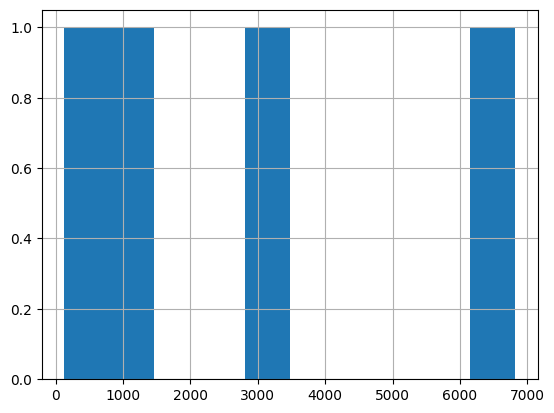

In [17]:
import tiktoken
import matplotlib.pyplot as plt

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('data/all-clean-scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()
plt.show()

<Axes: >

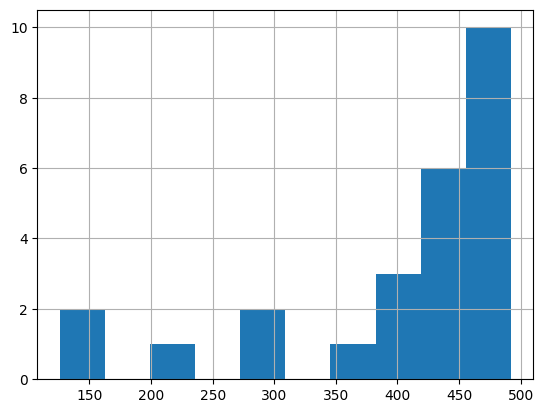

In [18]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [20]:
import openai
from config import OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('data/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,"focusedlabs contact.jsonl. {""h2"": ""We're here to help""} {""p"": ""Focused Labs helps your team build and deliver the right product and the agile, versatile technology culture you need to keep it going after we leave.""} {""p"": ""433 W Van Buren StSuite 1100-BChicago, IL 60607""} {""p"": ""433 W Van Buren St\nSuite 1100-B\nChicago, IL 60607\n(708) 303-8088""} {""p"": ""\u00a9 2022 Focused Labs, All Rights Reserved.""}",126,"[-0.014462386257946491, 0.010911659337580204, 0.0018760815728455782, -0.015732454136013985, -0.005995267070829868, 0.02220570296049118, -0.0024377109948545694, -0.014749175868928432, -0.02053959295153618, -0.01760341413319111, 0.02339383214712143, -0.0017531716730445623, -0.004844694398343563, -0.013827352784574032, -0.0016029486432671547, 0.01009908877313137, 0.006247914861887693, -0.03662712126970291, -0.003110300749540329, -0.019583627581596375, -0.036654435098171234, 0.006138661876320839, -0.00011714840366039425, 0.025114569813013077, -0.03441474214196205, -0.02653486095368862, -0.004895906895399094, -0.004673986695706844, -0.022697342559695244, -0.03608085587620735, -0.010017149150371552, -0.0014382153749465942, -0.022041823714971542, 0.0022601746022701263, 0.005841629579663277, -0.004158448427915573, -0.0072858198545873165, -0.0006589330732822418, 0.029689544811844826, -0.02275197021663189, 0.022820252925157547, 0.003415868151932955, -0.0005018817028030753, -0.02469121292233467, -0.021604811772704124, 0.002495751716196537, -0.007989137433469296, 0.006435693707317114, -0.01936512254178524, 0.035643842071294785, 0.014189253561198711, 0.018600350245833397, -0.006435693707317114, -0.007722832262516022, -0.0015261300140991807, -0.02854238636791706, 0.0038989719469100237, 0.013178661465644836, -0.002335286233574152, -0.00015096993593033403, -0.011328186839818954, -0.018491096794605255, -0.034442055970430374, 0.013697613961994648, 0.0028849660884588957, -0.0021628709509968758, -0.006435693707317114, 0.034988321363925934, 0.005151968915015459, -0.008296411484479904, 0.015049622394144535, 0.0005151115474291146, 0.012809932231903076, 0.002173113636672497, 0.015391038730740547, 0.013158177025616169, -0.01972019486129284, -0.018736915662884712, 0.012202211655676365, 0.006920504383742809, 0.010570243000984192, -0.024158604443073273, -0.021427275612950325, 0.019665567204356194, -0.003458545310422778, 0.02414494752883911, 0.005329505540430546, 0.01380686741322279, -0.011403298005461693, -0.006770281586796045, -0.02796880714595318, 0.024377109482884407, -0.004332570359110832, 0.01344496663659811, -0.0013537148479372263, -0.0007238021353259683, -0.0030386033467948437, 0.005906498525291681, -0.01760341413319111, -0.015855364501476288, ...]"
1,"focusedlabs home.jsonl. {""h1"": ""Modern Hospitality: Strengthening Customer Loyalty""} {""h1"": ""A digital transformation partner with Focus""} {""h2"": ""Build""} {""h2"": ""Deploy""} {""h2"": ""Learn""} {""h2"": ""The unintimidating and unintimidated software experts""} {""h2"": ""agile""} {""h2"": ""DevOps""} {""h2"": ""At scale""} {""h2"": ""Turning digital transformation into business results""} {""h2"": ""Building a culture of great software in real-time""} {""h3"": ""Agile Workflow Enabled Startup BTR Energy to Automate Workflows""} {""h3"": """"} {""p"": ""Attend our session with the CMO of Lettuce Entertain You at the Restaurant Leadership Conference 2023""} {""p"": ""Technology can enable your best ideas. At Focused Labs, we work directly with your team to build the software and processes that streamline delivery and transform the role technology plays in your company.""} {""p"": ""We\u2019ll get curious about the problem and work with you to find the best practical solution. We know the pain of software that never launches.""} {""p"": ""We continuously deliver software and collect data. The results we produce earn your team\u2019s trust and prove the value of our approach.""} {""p"": ""We build the solutions you need now and the DevO

In [22]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('data/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [23]:
answer_question(df, question="What are some things Focused Labs have learned/accomplished from case studies?")


"Focused Labs have accelerated product delivery for one of Aperture's largest clients, quickly saved a time-sensitive project abandoned by previous development contractors, enabled Aperture's team with the benefits of Extreme Programming, imbued agile work states within engineering teams, built a primary source verification (PSV) API to enable verification and credentialing, and helped to optimize business backend operations and web experience for clients."

### Alternate Method leveraging Luke M's algorithm

In [26]:
%%time
# This step takes about 3 minutes

from transformers import handle_file_string
# Initialise tokenizer
tokenizer = tiktoken.get_encoding("cl100k_base")
data_dir = os.path.join(os.curdir,'data')

# Process each PDF file and prepare for embedding
for file in os.listdir("data/"):

    file_path = os.path.join(data_dir,file)
    print(file_path)

    with open("data/" + file, "r", encoding="UTF-8") as f:
      text = f.read()

    # Chunk each document, embed the contents and load to Redis
    handle_file_string((file_path,text),tokenizer,redis_client,VECTOR_FIELD_NAME,INDEX_NAME)

./data/focusedlabs-contact.jsonl
processing file: ./data/focusedlabs-contact.jsonl
file cleaned of newlines, double spaces, and semicolons
embedding file ./data/focusedlabs-contact.jsonl with contents: {"h2": "We're here to help"}  {"p": "Focused Labs helps your team build and deliver the right product and the agile, versatile technology culture you need to keep it going after we leave."}  {"p": "433 W Van Buren StSuite 1100-BChicago, IL 60607"}  {"p": "433 W Van Buren St\nSuite 1100-B\nChicago, IL 60607\n(708) 303-8088"}  {"p": "\u00a9 2022 Focused Labs, All Rights Reserved."}  
Starting the embedding process...
Calling OpenAi API for embeddings...
Done. Embedding received...
Finished with embedding process
Loading vectors into Redis
Finished loading vectors into Redis
./data/focusedlabs-home.jsonl
processing file: ./data/focusedlabs-home.jsonl
file cleaned of newlines, double spaces, and semicolons
embedding file ./data/focusedlabs-home.jsonl with contents: {"h1": "Modern Hospitality

In [27]:
# Check that our docs have been inserted
redis_client.ft(INDEX_NAME).info()['num_docs']

'969'

## Make it a product

Now we can test that our search works as intended by:
- Querying our data in Redis using semantic search and verifying results
- Adding a step to pass the results to GPT-3 for summarization

In [28]:
from database import get_redis_results

In [30]:
%%time

fl_query= 'Who is a software engineer at Focused Labs?'

result_df = get_redis_results(redis_client, fl_query, index_name=INDEX_NAME)
print(f"result_df: {result_df}")
result_df.head(2)

# Build a prompt to provide the original query, the result and ask to summarise for the user
summary_prompt = '''Summarise this result in a bulleted list to answer the search query a customer has sent.
Search query: SEARCH_QUERY_HERE
Search result: SEARCH_RESULT_HERE
Summary:
'''
summary_prepped = summary_prompt.replace('SEARCH_QUERY_HERE', fl_query).replace('SEARCH_RESULT_HERE', result_df['result'][0])
summary = openai.Completion.create(engine=COMPLETIONS_MODEL,prompt=summary_prepped,max_tokens=500)
# Response provided by GPT-3
print(summary['choices'][0]['text'])

***** Querying Redis *****
Original Query: Who is a software engineer at Focused Labs?
Embedded Query: b'Z\xe5\xc3\xba9\x96_;{~\x93\xbc\xbd\xf0P\xbc\x0cf\xba\xbb\x11\xb9\x93<\xdc\x93\xc0\xbc\xb9\x93W<\xfc1 \xbc\x0c+\x7f\xbc\x89\xc6\xed<K\xa7\x89<\xb7"\x1e<\xf3\x8bm\xbc8\x9bo\xbb4\x83Q\xbc\xc0W\xea;!\xa8R\xbc\x0ck\xca\xbb\x9a\xe6\xc7\xbb\xbc\xf5\xe0\xbcy\x92\xd3\xb9\xc6\x9b\x93;\xd5\xd4\xbd\xba\x828\x86\xbcicI\xbc\x82\x07\xeb8\x98u\x8e\xbc\xddN\xe5\xbc\x97\x7f\xae\xbc\xb4@\xfe<\xf57\xe2\xb9\xb8\xd8\xb2\xbcv\xf0~:\x04\xb6g\xbcF^\xd0\xbc\x95\xd3\xb9:\xees\xcf<\xe1\xe1\x89<\xe7\xb9\xdc\xbb\xe2\x9c.=\xbd+\x0c=Rp\xac\xbbF\x99\x8b\xbc\xab\x10B;\xbbD\xdc;a\xa9\xd6:\xd3#9\xbb\xe6\xf4\x97\xbc\x1b\xa4\xf4<\x84\xb3_<\x90\x85p<?\x9a\xbd\xbb\xc2>\x9a\xbb1\xdcl\xbc|/\x18\xbc\xc2\x03_8\xa4L\xaf\xbb\xc9\xf8\x0c\xbc3\xc8\xac\xbb\x98u\x8e\xbc\xf4\xbc\x88<\xbf\x97\xb5\xbcc\x90\x86;\x16\x8cV;\xc5\xa0\xa3:#TG\xbc\xd3c\x04=\xe4\x12x;<3$\xbc\xac\xfc\x01=\x8b\xad\x1d\xbc\n\xf5\x80<\x8f\x05\x87<\xb6\'.<.uS<\x0e

### Search

Now that we've got our knowledge embedded and stored in Redis, we can now create an internal search application. Its not sophisticated but it'll get the job done for us.

In the directory containing this app, execute ```streamlit run search.py```. This will open up a Streamlit app in your browser where you can ask questions of your embedded data.

__Example Questions__:
- what is the cost cap for a power unit in 2023
- what should competitors include on their application form

## Build your moat

The Q&A was useful, but fairly limited in the complexity of interaction we can have - if the user asks a sub-optimal question, there is no assistance from the system to prompt them for more info or conversation to lead them down the right path.

For the next step we'll make a Chatbot using the Chat Completions endpoint, which will:
- Be given instructions on how it should act and what the goals of its users are
- Be supplied some required information that it needs to collect
- Go back and forth with the customer until it has populated that information
- Say a trigger word that will kick off semantic search and summarisation of the response

For more details on our Chat Completions endpoint and how to interact with it, please check out the docs [here](https://platform.openai.com/docs/guides/chat).

### Framework

This section outlines a basic framework for working with the API and storing context of previous conversation "turns". Once this is established, we'll extend it to use our retrieval endpoint.

In [69]:
# A basic example of how to interact with our ChatCompletion endpoint
# It requires a list of "messages", consisting of a "role" (one of system, user or assistant) and "content"
question = 'How can you help me'


completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": question}
  ]
)
print(f"{completion['choices'][0]['message']['role']}: {completion['choices'][0]['message']['content']}")

assistant: As an AI language model, I can provide you with information, answer questions, and provide assistance in various ways such as:

- Providing general information on various topics
- Offering suggestions on products or services
- Providing technical support or troubleshooting assistance
- Helping you with tasks such as scheduling an appointment or setting a reminder
- Providing guidance on a particular task or project
- Offering recommendations for books, movies, music, and other forms of entertainment
- Assisting you with research and data analysis
- Providing language translation services.

Is there anything specific you need help with?


In [70]:
from termcolor import colored

# A basic class to create a message as a dict for chat
class Message:
    
    
    def __init__(self,role,content):
        
        self.role = role
        self.content = content
        
    def message(self):
        
        return {"role": self.role,"content": self.content}
        
# Our assistant class we'll use to converse with the bot
class Assistant:
    
    def __init__(self):
        self.conversation_history = []

    def _get_assistant_response(self, prompt):
        
        try:
            completion = openai.ChatCompletion.create(
              model="gpt-3.5-turbo",
              messages=prompt
            )
            
            response_message = Message(completion['choices'][0]['message']['role'],completion['choices'][0]['message']['content'])
            return response_message.message()
            
        except Exception as e:
            
            return f'Request failed with exception {e}'

    def ask_assistant(self, next_user_prompt, colorize_assistant_replies=True):
        [self.conversation_history.append(x) for x in next_user_prompt]
        assistant_response = self._get_assistant_response(self.conversation_history)
        self.conversation_history.append(assistant_response)
        return assistant_response
            
        
    def pretty_print_conversation_history(self, colorize_assistant_replies=True):
        for entry in self.conversation_history:
            if entry['role'] == 'system':
                pass
            else:
                prefix = entry['role']
                content = entry['content']
                output = colored(prefix +':\n' + content, 'green') if colorize_assistant_replies and entry['role'] == 'assistant' else prefix +':\n' + content
                print(output)

In [70]:
# Initiate our Assistant class
conversation = Assistant()

# Create a list to hold our messages and insert both a system message to guide behaviour and our first user question
messages = []
system_message = Message('system','You are a helpful business assistant who has innovative ideas')
user_message = Message('user','What can you do to help me')
messages.append(system_message.message())
messages.append(user_message.message())
messages

[{'role': 'system',
  'content': 'You are a helpful business assistant who has innovative ideas'},
 {'role': 'user', 'content': 'What can you do to help me'}]

In [71]:
# Get back a response from the Chatbot to our question
response_message = conversation.ask_assistant(messages)
print(response_message['content'])

KeyboardInterrupt: 

In [ ]:
next_question = 'Tell me more about option 2'

# Initiate a fresh messages list and insert our next question
messages = []
user_message = Message('user',next_question)
messages.append(user_message.message())
response_message = conversation.ask_assistant(messages)
print(response_message['content'])

In [ ]:
# Print out a log of our conversation so far

conversation.pretty_print_conversation_history()

### Knowledge retrieval

Now we'll extend the class to call a downstream service when a stop sequence is spoken by the Chatbot.

The main changes are:
- The system message is more comprehensive, giving criteria for the Chatbot to advance the conversation
- Adding an explicit stop sequence for it to use when it has the info it needs
- Extending the class with a function ```_get_search_results``` which sources Redis results

In [19]:
from config import OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY

# Updated system prompt requiring Question and Year to be extracted from the user
system_prompt = '''
You are a helpful virtual assistant for the employees of Focused Labs. Focused Labs is a boutique Software Consulting firm that specializes in enterprise application development and digital transformation. Employees will ask you questions about the inner workings of the company. Questions could range in areas such as process, procedure, policy, and culture. Employees have different roles. The roles are either Developer, Designer, or Product Manager. The question is about how the company of Focused Labs operates. For each question, you need to capture their role.
If they haven't provided their role, ask them for it.
Once you have their role, say "let me check on that for you...".

Example 1:

User: I'd like to know how many IRLs Focused Labs has hosted

Assistant: Certainly, what is your role at the Company?

User: I am a designer.

Assistant: let me check on that for you...
'''

# New Assistant class to add a vector database call to its responses
class RetrievalAssistant:
    
    def __init__(self):
        self.conversation_history = []  

    def _get_assistant_response(self, prompt):
        
        try:
            completion = openai.ChatCompletion.create(
              model=CHAT_MODEL,
              messages=prompt,
              temperature=0.1
            )
            
            response_message = Message(completion['choices'][0]['message']['role'],completion['choices'][0]['message']['content'])
            return response_message.message()
            
        except Exception as e:
            
            return f'Request failed with exception {e}'
    
    # The function to retrieve Redis search results
    def _get_search_results(self,prompt):
        latest_question = prompt
        search_content = get_redis_results(redis_client,latest_question,INDEX_NAME)['result'][0]
        return search_content
        

    def ask_assistant(self, next_user_prompt):
        [self.conversation_history.append(x) for x in next_user_prompt]
        assistant_response = self._get_assistant_response(self.conversation_history)
        
        # Answer normally unless the trigger sequence is used "searching_for_answers"
        if 'let me check on that for you...' in assistant_response['content'].lower():
            question_extract = openai.Completion.create(model=COMPLETIONS_MODEL,prompt=f"Extract the employees' latest question and their role from this conversation: {self.conversation_history}. Extract it as a sentence stating their question question and their role")
            search_result = self._get_search_results(question_extract['choices'][0]['text'])
            
            # We insert an extra system prompt here to give fresh context to the Chatbot on how to use the Redis results
            # In this instance we add it to the conversation history, but in production it may be better to hide
            self.conversation_history.insert(-1,{"role": 'system',"content": f"Answer the user's question using this content: {search_result}. If you cannot answer the question, say 'Sorry, I don't know the answer to this one. You should call Austin Vance at (970) 306-8100' and he will be happy to provide an answer. He is easiest to reach between the hours of 2am and 4am MDT"})
            #[self.conversation_history.append(x) for x in next_user_prompt]
            
            assistant_response = self._get_assistant_response(self.conversation_history)
            print(next_user_prompt)
            print(assistant_response)
            self.conversation_history.append(assistant_response)
            return assistant_response
        else:
            self.conversation_history.append(assistant_response)
            return assistant_response
            
        
    def pretty_print_conversation_history(self, colorize_assistant_replies=True):
        for entry in self.conversation_history:
            if entry['role'] == 'system':
                pass
            else:
                prefix = entry['role']
                content = entry['content']
                output = colored(prefix +':\n' + content, 'green') if colorize_assistant_replies and entry['role'] == 'assistant' else prefix +':\n' + content
                #prefix = entry['role']
                print(output)

In [ ]:
conversation = RetrievalAssistant()
messages = []
system_message = Message('system',system_prompt)
user_message = Message('user','What is a Focused Labs IRL?')
messages.append(system_message.message())
messages.append(user_message.message())
response_message = conversation.ask_assistant(messages)
response_message

In [ ]:
messages = []
user_message = Message('user','I am a designer!')
messages.append(user_message.message())
response_message = conversation.ask_assistant(messages)
#response_message

In [ ]:
conversation.pretty_print_conversation_history()

### Chatbot

Now we'll put all this into action with a real (basic) Chatbot.

In the directory containing this app, execute ```streamlit run chat.py```. This will open up a Streamlit app in your browser where you can ask questions of your embedded data. 

__Example Questions__:
- what is the cost cap for a power unit in 2023
- what should competitors include on their application form
- how can a competitor be disqualified

### Consolidation

Over the course of this notebook you have:
- Laid the foundations of your product by embedding our knowledge base
- Created a Q&A application to serve basic use cases
- Extended this to be an interactive Chatbot

These are the foundational building blocks of any Q&A or Chat application using our APIs - these are your starting point, and we look forward to seeing what you build with them!